In [324]:
# pip install spacy

In [325]:
# pip install numpy==1.22.0

In [326]:
# Import Statements
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import string
import regex as re

from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk import word_tokenize
from nltk import FreqDist

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn import set_config

from PIL import Image
from wordcloud import WordCloud
from textwrap import wrap
import joblib

In [327]:
# py -m pip cache purge

# from pydantic._internal._model_construction import ModelMetaclass
# from pydantic.main import ModelMetaclass
# import spacy

In [328]:
df = pd.read_csv('/Users/rosew/Desktop/Moringa/phase_5/Travel-WordFinder/Data/best_travel_destinations_for_2025.csv')

df.head()

,Attraction,Description,Country,Continent
0,Amboseli National Park,Amboseli belongs in the elite of Kenya’s natio...,Kenya,Africa
1,Fort Jesus,This 16th-century fort and Unesco World Herita...,Kenya,Africa
2,David Sheldrick Wildlife Trust,"Occupying a plot within Nairobi National Park,...",Kenya,Africa
3,Nairobi National Park,Welcome to Kenya’s most accessible yet incongr...,Kenya,Africa
4,National Museum,"Kenya’s wonderful National Museum, housed in a...",Kenya,Africa


# Explore/Clean The Data

In [329]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18040 entries, 0 to 18039
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attraction   18040 non-null  object
 1   Description  18040 non-null  object
 2   Country      18040 non-null  object
 3   Continent    18040 non-null  object
dtypes: object(4)
memory usage: 563.9+ KB


In [330]:

df.describe()

,Attraction,Description,Country,Continent
count,18040,18040,18040,18040
unique,17185,18024,25,7
top,Cathedral,Buddhist ruins in Si Satchanalai-Chaliang Hist...,Canada,Asia
freq,19,4,1200,4480


In [331]:
df. shape

(18040, 4)

In [332]:
#No null values because we scraped everything ourselves. Just to double-check:
df.isna().sum()

Attraction     0
Description    0
Country        0
Continent      0
dtype: int64

## Duplicates

In [333]:
df.duplicated().sum()

9

In [334]:
all_duplicates = df[df.duplicated(keep=False)]
print(all_duplicates)

                                   Attraction  \
3439                              Yuexiu Park   
3440                              Yuexiu Park   
3479   Palace of Moon & Water Kwun Yum Temple   
3480   Palace of Moon & Water Kwun Yum Temple   
3639                       Rakadrak Hermitage   
3640                       Rakadrak Hermitage   
3679                          Huilan Pavilion   
3680                          Huilan Pavilion   
4999                         Pithoragarh Fort   
5000                         Pithoragarh Fort   
5157                    Himadri Hans Handloom   
5160                    Himadri Hans Handloom   
11559                             Kids Market   
11560                             Kids Market   
11637        Africville Heritage Trust Museum   
11641        Africville Heritage Trust Museum   
14359                       Cementerios 1 & 2   
14360                       Cementerios 1 & 2   

                                             Description Country  \


The duplicated attraction is Grimspound in England. Since it contains the same exact attraction, we can drop it from the dataframe

In [335]:
df = df.drop_duplicates()

In [336]:
all_duplicates = df[df.duplicated(keep=False)]
print(all_duplicates)

Empty DataFrame
Columns: [Attraction, Description, Country, Continent]
Index: []


In [337]:
# df.to_csv('/Users/rosew/Downloads/best_travel_destinations_for_2025_df_cleaned.csv')

## Class Imbalance

In [338]:
display(df.Country.unique())
print('Total Unique Countries:', len(df.Country.unique()))

array(['Kenya', 'South Africa', 'Egypt', 'Morocco', 'Japan', 'China',
       'India', 'Thailand', 'France', 'Italy', 'Germany', 'United States',
       'Canada', 'Mexico', 'Brazil', 'Argentina', 'Chile', 'Peru',
       'Australia', 'New Zealand', 'Fiji', 'United Arab Emirates',
       'Turkey', 'Israel', 'Jordan'], dtype=object)

Total Unique Countries: 25


In [339]:
df.Country.value_counts(normalize=True)

Country
Germany                 0.066552
France                  0.066552
Australia               0.066552
United States           0.066552
Japan                   0.066552
Italy                   0.066552
Canada                  0.066441
India                   0.066441
China                   0.066330
Mexico                  0.059897
Turkey                  0.057678
Thailand                0.048805
South Africa            0.035494
Brazil                  0.033276
Egypt                   0.028839
New Zealand             0.022184
Morocco                 0.019966
Argentina               0.019966
Peru                    0.019966
Chile                   0.017692
Israel                  0.008874
Kenya                   0.008874
Jordan                  0.008874
United Arab Emirates    0.006655
Fiji                    0.004437
Name: proportion, dtype: float64

In [340]:
countries = df.groupby('Country').count()

In [341]:

countries.reset_index(inplace=True)

In [342]:
sorted_countries = countries.sort_values(by='Attraction', ascending=False)
sorted_countries

,Country,Attraction,Description,Continent
12,Italy,1200,1200,1200
8,France,1200,1200,1200
13,Japan,1200,1200,1200
1,Australia,1200,1200,1200
9,Germany,1200,1200,1200
24,United States,1200,1200,1200
10,India,1198,1198,1198
3,Canada,1198,1198,1198
5,China,1196,1196,1196
16,Mexico,1080,1080,1080


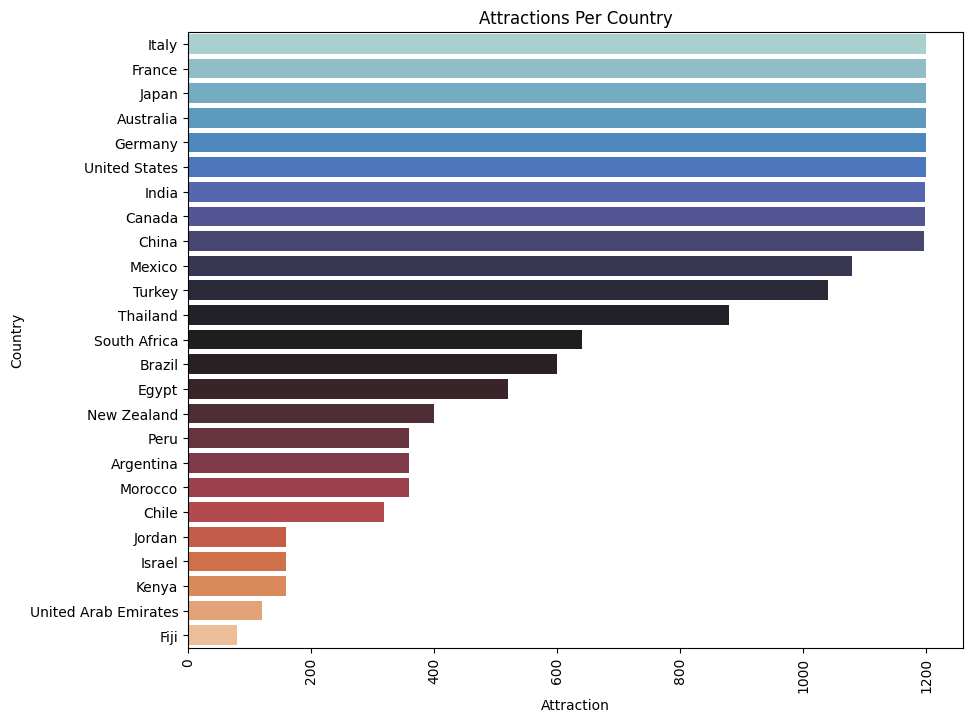

In [343]:
# Plot the class imbalance
plt.figure(figsize=(10,8))
sns.barplot(x='Attraction', y='Country', data=sorted_countries, palette='icefire')
plt.title('Attractions Per Country')
plt.xticks(rotation=90)
plt.show()

**This will likely be an issue when modeling, so I will try to use class weights to fix this problem**

# Text Cleaning, Preprocessing, and Further Exploration
- Removing punctuation and numbers
- Lowercasing everything
- Removing stopwords
- Creating a document term matrix grouped by Country
  - Count Vectorization
  - TF-IDF Vectorization
  - Bi-grams
- Creating a document term matrix grouped by Continent
  - Count Vectorization
  - TF-IDF Vectorization
  - Bi-grams
- Visualize most frequent words
  - Word clouds
  - Bar plot or histogram


In [344]:
# Create a list of stop words
stopwords_list = stopwords.words('english')
stopwords_list+= list(string.punctuation)

In [345]:
# Preview the list
stopwords_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [346]:
# Save stopwords list for app
# joblib.dump(stopwords_list, '/Users/tiaplagata/Documents/Flatiron/capstone-project/Data/stopwords_list')

In [347]:
# Lowercase all words in each corpus
df_to_clean = df.copy()
df_to_clean['Cleaned'] = df_to_clean['Description'].apply(lambda x: x.lower())
df_to_clean

,Attraction,Description,Country,Continent,Cleaned
0,Amboseli National Park,Amboseli belongs in the elite of Kenya’s natio...,Kenya,Africa,amboseli belongs in the elite of kenya’s natio...
1,Fort Jesus,This 16th-century fort and Unesco World Herita...,Kenya,Africa,this 16th-century fort and unesco world herita...
2,David Sheldrick Wildlife Trust,"Occupying a plot within Nairobi National Park,...",Kenya,Africa,"occupying a plot within nairobi national park,..."
3,Nairobi National Park,Welcome to Kenya’s most accessible yet incongr...,Kenya,Africa,welcome to kenya’s most accessible yet incongr...
4,National Museum,"Kenya’s wonderful National Museum, housed in a...",Kenya,Africa,"kenya’s wonderful national museum, housed in a..."
...,...,...,...,...,...
18035,Byzantine Basilica,Near the Citadel's archaeological museum is th...,Jordan,Middle East,near the citadel's archaeological museum is th...
18036,Sharif Al Hussein Bin Ali Mosque,This grand and beautiful gleaming white mosque...,Jordan,Middle East,this grand and beautiful gleaming white mosque...
18037,North Theatre,The North Theatre is overgrown and missing muc...,Jordan,Middle East,the north theatre is overgrown and missing muc...
18038,Shops,The shells of a row of shops remain in the wes...,Jordan,Middle East,the shells of a row of shops remain in the wes...


In [348]:
# Remove commas, hyphens, colons, and other punctuation
df_to_clean['Cleaned'] = df_to_clean['Cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df_to_clean.head()

,Attraction,Description,Country,Continent,Cleaned
0,Amboseli National Park,Amboseli belongs in the elite of Kenya’s natio...,Kenya,Africa,amboseli belongs in the elite of kenya’s natio...
1,Fort Jesus,This 16th-century fort and Unesco World Herita...,Kenya,Africa,this 16thcentury fort and unesco world heritag...
2,David Sheldrick Wildlife Trust,"Occupying a plot within Nairobi National Park,...",Kenya,Africa,occupying a plot within nairobi national park ...
3,Nairobi National Park,Welcome to Kenya’s most accessible yet incongr...,Kenya,Africa,welcome to kenya’s most accessible yet incongr...
4,National Museum,"Kenya’s wonderful National Museum, housed in a...",Kenya,Africa,kenya’s wonderful national museum housed in an...


In [349]:
# Use regex to get rid of numbers 
df_to_clean['Cleaned'] = df_to_clean['Cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
df_to_clean.head(10)

,Attraction,Description,Country,Continent,Cleaned
0,Amboseli National Park,Amboseli belongs in the elite of Kenya’s natio...,Kenya,Africa,amboseli belongs in the elite of kenya’s natio...
1,Fort Jesus,This 16th-century fort and Unesco World Herita...,Kenya,Africa,this fort and unesco world heritage treasure ...
2,David Sheldrick Wildlife Trust,"Occupying a plot within Nairobi National Park,...",Kenya,Africa,occupying a plot within nairobi national park ...
3,Nairobi National Park,Welcome to Kenya’s most accessible yet incongr...,Kenya,Africa,welcome to kenya’s most accessible yet incongr...
4,National Museum,"Kenya’s wonderful National Museum, housed in a...",Kenya,Africa,kenya’s wonderful national museum housed in an...
5,Giraffe Centre,"This centre, which protects the highly endange...",Kenya,Africa,this centre which protects the highly endanger...
6,Lamu Museum,The best museum in town (and the second best i...,Kenya,Africa,the best museum in town and the second best in...
7,Galana River,Running through the heart of the park and mark...,Kenya,Africa,running through the heart of the park and mark...
8,Mzima Springs,Mzima Springs is an oasis of green in the west...,Kenya,Africa,mzima springs is an oasis of green in the west...
9,Ngulia Rhino Sanctuary,"At the base of Ngulia Hills, this 90-sq-km are...",Kenya,Africa,at the base of ngulia hills this area is surr...


In [350]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [351]:
# Lemmatize the text using spacy
lemmatized = spacy.load('en_core_web_sm')

df_to_clean['Lemmatized'] = df_to_clean['Cleaned'].apply(lambda x: ' '.join(
                                    [token.lemma_ for token in list(lemmatized(x)) if (token.is_stop==False)]))
df_to_clean.head(10)

,Attraction,Description,Country,Continent,Cleaned,Lemmatized
0,Amboseli National Park,Amboseli belongs in the elite of Kenya’s natio...,Kenya,Africa,amboseli belongs in the elite of kenya’s natio...,amboseli belong elite kenya national park easy...
1,Fort Jesus,This 16th-century fort and Unesco World Herita...,Kenya,Africa,this fort and unesco world heritage treasure ...,fort unesco world heritage treasure mombasa ...
2,David Sheldrick Wildlife Trust,"Occupying a plot within Nairobi National Park,...",Kenya,Africa,occupying a plot within nairobi national park ...,occupy plot nairobi national park nonprofit tr...
3,Nairobi National Park,Welcome to Kenya’s most accessible yet incongr...,Kenya,Africa,welcome to kenya’s most accessible yet incongr...,welcome kenya accessible incongruous safari ex...
4,National Museum,"Kenya’s wonderful National Museum, housed in a...",Kenya,Africa,kenya’s wonderful national museum housed in an...,kenya wonderful national museum house impose b...
5,Giraffe Centre,"This centre, which protects the highly endange...",Kenya,Africa,this centre which protects the highly endanger...,centre protect highly endanger rothschild gira...
6,Lamu Museum,The best museum in town (and the second best i...,Kenya,Africa,the best museum in town and the second best in...,good museum town second good kenya house grand...
7,Galana River,Running through the heart of the park and mark...,Kenya,Africa,running through the heart of the park and mark...,run heart park mark northernmost point park vi...
8,Mzima Springs,Mzima Springs is an oasis of green in the west...,Kenya,Africa,mzima springs is an oasis of green in the west...,mzima spring oasis green west park produce inc...
9,Ngulia Rhino Sanctuary,"At the base of Ngulia Hills, this 90-sq-km are...",Kenya,Africa,at the base of ngulia hills this area is surr...,base ngulia hill area surround electric fe...


In [352]:
# Group the corpora by Country and join them
df_to_group = df_to_clean[['Country', 'Lemmatized']]
df_grouped = df_to_group.groupby(by='Country').agg(lambda x:' '.join(x))
df_grouped

,Lemmatized
Country,
Argentina,earth dynamic accessible ice field glaciar per...
Australia,definitively sydney bondi world great beach cl...
Brazil,tijuca s leave atlantic rainforest surround ri...
Canada,canada sight banff national park justifiably r...
Chile,dub serengeti southern cone parque nacional ...
China,cablehaule funicular railway scale ascent hi...
Egypt,amunra local god karnak luxor new kingdom prin...
Fiji,coloisuva pronounce tholoeesoova oasis lush ...
France,fantastic space museum citys eastern outskirt ...


In [353]:
# # Save grouped df
# df_grouped.to_csv('../Data/df_grouped')

## Look at different vectorization strategies
- Try different vectorization strategies and visualize them with word clouds  
  - Count Vectorization
  - TF-IDF Vectorization
  - Bi-grams

In [354]:
# Create a document term matrix using count vectorization
# Using count vectorization (most simple way to vectorize)
cv = CountVectorizer(analyzer='word', stop_words=stopwords_list)
data = cv.fit_transform(df_grouped['Lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names_out())
df_dtm.index = df_grouped.index
df_dtm

,aachen,aah,aalara,aalto,aaron,aaronsohn,aarti,aath,ab,abaca,...,饶平,骑楼,高北,鯉城,鸟巢,黄山,黄羊河水库,黑虎泉,黔灵山,龙潭
Country,,,,,,,,,,,,,,,,,,,,,
Argentina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Australia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brazil,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Canada,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chile,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
China,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,1
Egypt,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Fiji,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
France,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [355]:
# Create a document term matrix using TF-IDF vectorization
# Might be good for classifying cities
tfidf = TfidfVectorizer(analyzer='word', stop_words=stopwords_list)
data2 = tfidf.fit_transform(df_grouped['Lemmatized'])
df_dtm2 = pd.DataFrame(data2.toarray(), columns=tfidf.get_feature_names_out())
df_dtm2.index = df_grouped.index
df_dtm2

,aachen,aah,aalara,aalto,aaron,aaronsohn,aarti,aath,ab,abaca,...,饶平,骑楼,高北,鯉城,鸟巢,黄山,黄羊河水库,黑虎泉,黔灵山,龙潭
Country,,,,,,,,,,,,,,,,,,,,,
Argentina,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Australia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Brazil,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Canada,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Chile,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
China,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004299,0.004299,0.004299,0.000000,0.004299,0.004299,0.004299,0.004299,0.004299,0.004299
Egypt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007706,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fiji,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038957,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
France,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Word Clouds with Count Vectorization

In [356]:
def generate_wordcloud(data, title):
    cloud = WordCloud(width=400, height=330, max_words=150, colormap='tab20c').generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('\n'.join(wrap(title,60)), fontsize=13)
    plt.show()

In [357]:
# # Transposing document term matrix
# df_dtm = df_dtm.transpose()

# # Plotting word cloud for each Country
# for index, country in enumerate(df_dtm.columns):
#     generate_wordcloud(df_dtm[country].sort_values(ascending=False), country)

In [358]:
# Look at top words with count vectorizer (in total, not per country)
sum_words = data.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq

[('museum', 2567),
 ('build', 1694),
 ('park', 1381),
 ('house', 1213),
 ('art', 1043),
 ('old', 1040),
 ('building', 992),
 ('temple', 968),
 ('city', 965),
 ('town', 962),
 ('small', 920),
 ('de', 881),
 ('large', 874),
 ('beach', 850),
 ('church', 844),
 ('century', 755),
 ('include', 752),
 ('collection', 734),
 ('south', 715),
 ('home', 694),
 ('view', 667),
 ('site', 667),
 ('north', 666),
 ('main', 637),
 ('date', 619),
 ('good', 616),
 ('centre', 589),
 ('garden', 588),
 ('history', 587),
 ('place', 569),
 ('local', 554),
 ('national', 519),
 ('world', 513),
 ('tower', 512),
 ('display', 500),
 ('island', 500),
 ('river', 489),
 ('area', 477),
 ('gallery', 477),
 ('beautiful', 476),
 ('great', 465),
 ('work', 461),
 ('village', 461),
 ('know', 456),
 ('west', 453),
 ('exhibit', 450),
 ('design', 442),
 ('road', 434),
 ('visit', 431),
 ('walk', 404),
 ('feature', 403),
 ('east', 401),
 ('lake', 400),
 ('fine', 398),
 ('end', 381),
 ('impressive', 381),
 ('hill', 381),
 ('locate'

One of the top words is 'km', short for kilometer which does not point to anything unique in a country. Others are small, large, de(Frech for of), Include, Know, like, sq, la, di, and ad. We could consider adding these to the stop words list

### Word Clouds with TF-IDF Vectorization

In [359]:
# # Transposing document term matrix
# df_dtm2 = df_dtm2.transpose()

# # Plotting word cloud for each country
# for index, country in enumerate(df_dtm2.columns):
#     generate_wordcloud(df_dtm2[country].sort_values(ascending=False), country)

In [360]:
# Look at top words with tf-idf vectorization (for total words, not per country)
sum_words = data2.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq

[('museum', 4.338283338806132),
 ('build', 2.847216592794639),
 ('park', 2.5753723067208036),
 ('house', 2.102425356015084),
 ('de', 2.059704840493331),
 ('art', 1.7656707773228493),
 ('building', 1.7376203154296406),
 ('small', 1.6824509665578642),
 ('city', 1.6807341150324604),
 ('old', 1.6741619719375596),
 ('temple', 1.629421021562768),
 ('town', 1.6075814968969786),
 ('beach', 1.573155156763898),
 ('church', 1.5325291672646273),
 ('large', 1.4327499375576518),
 ('south', 1.3920435015921524),
 ('include', 1.304976692761858),
 ('collection', 1.2838694455284616),
 ('home', 1.22015859675164),
 ('centre', 1.2123364635629348),
 ('site', 1.204143841691344),
 ('view', 1.2022062525767454),
 ('century', 1.2007211189321696),
 ('good', 1.1508064384968038),
 ('north', 1.1223390276849725),
 ('main', 1.1194253205862286),
 ('national', 1.0430464560375223),
 ('place', 1.0342379718543102),
 ('local', 1.0168724432030274),
 ('history', 1.012455382710214),
 ('date', 0.9968196462429081),
 ('garden', 0.

This is very similar to the top words to count vectorication, with words like km, de,include, being repeated. However, there is no much overlap since TF-IFD finds more words thata re unique to the countries, telling is that this is probably a better technique.

## Bi-Grams

In [361]:
cv2 = CountVectorizer(analyzer='word', stop_words=stopwords_list, ngram_range=(2,2))
data3 = cv2.fit_transform(df_grouped['Lemmatized'])
df_dtm3 = pd.DataFrame(data3.toarray(), columns=cv2.get_feature_names_out())
df_dtm3.index = df_grouped.index
df_dtm3
# Transposing document term matrix
df_dtm3 = df_dtm3.transpose()
# Look at top bi-grams (in total, not per country)
sum_words = data3.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv2.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq

[('national park', 303),
 ('de la', 131),
 ('small museum', 129),
 ('museum house', 119),
 ('date century', 101),
 ('old town', 99),
 ('art museum', 95),
 ('sq km', 92),
 ('contemporary art', 86),
 ('build century', 86),
 ('museum display', 84),
 ('art gallery', 82),
 ('world heritage', 79),
 ('look like', 72),
 ('worth visit', 68),
 ('early century', 67),
 ('buddhist temple', 66),
 ('world large', 65),
 ('museum showcase', 64),
 ('originally build', 63),
 ('southern end', 63),
 ('church build', 62),
 ('guide tour', 60),
 ('old city', 58),
 ('city centre', 57),
 ('plaza de', 54),
 ('good place', 54),
 ('main road', 50),
 ('excellent museum', 49),
 ('museum feature', 49),
 ('heritage site', 49),
 ('de san', 49),
 ('northern end', 49),
 ('unesco world', 47),
 ('nature reserve', 47),
 ('bell tower', 47),
 ('city hall', 46),
 ('well know', 46),
 ('museum dedicate', 45),
 ('cultural center', 44),
 ('visitor centre', 44),
 ('city wall', 44),
 ('parque nacional', 43),
 ('beautifully restore',

This gives us a better indication of the words that we should remove since they are creating noise in the data but are commonly featured in the countries. These are:
- sq, km, south, north, west, east, de, la, southeast, northeast, northwest, look, like, southwest, de, san, and northern. Now that we have confirmation, we will add them to our stop words lists to make our data cleaner for visualizations and analysis. 

## Removing Noise from the Data

We need to remove these words that are not unique to countries.

In [362]:
# let's add hese words to the stopwords list
stopwords_list += ['sq', 'km', 'south', 'west', 'north', 'east', 'de', 'la', 'southeast', 'northeast', 'northwest', 'look', 'like', 'southwest', 'de', 'san', 'northern']

In [363]:
# Check whether this has worked.
cv2 = CountVectorizer(analyzer='word', stop_words=stopwords_list, ngram_range=(2,2))
data3 = cv2.fit_transform(df_grouped['Lemmatized'])
df_dtm3 = pd.DataFrame(data3.toarray(), columns=cv2.get_feature_names_out())
df_dtm3.index = df_grouped.index
df_dtm3
# Transposing document term matrix
df_dtm3 = df_dtm3.transpose()
# Look at top bi-grams (in total, not per country)
sum_words = data3.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv2.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

words_freq

[('national park', 303),
 ('small museum', 129),
 ('museum house', 119),
 ('date century', 101),
 ('old town', 99),
 ('art museum', 95),
 ('contemporary art', 86),
 ('build century', 86),
 ('museum display', 84),
 ('art gallery', 82),
 ('world heritage', 79),
 ('worth visit', 68),
 ('early century', 67),
 ('buddhist temple', 66),
 ('world large', 65),
 ('museum showcase', 64),
 ('originally build', 63),
 ('southern end', 63),
 ('church build', 62),
 ('guide tour', 60),
 ('old city', 58),
 ('city centre', 57),
 ('good place', 54),
 ('main road', 50),
 ('excellent museum', 49),
 ('museum feature', 49),
 ('heritage site', 49),
 ('unesco world', 47),
 ('nature reserve', 47),
 ('bell tower', 47),
 ('city hall', 46),
 ('well know', 46),
 ('museum dedicate', 45),
 ('cultural center', 44),
 ('visitor centre', 44),
 ('city wall', 44),
 ('parque nacional', 43),
 ('beautifully restore', 43),
 ('late century', 42),
 ('cultural centre', 42),
 ('botanical garden', 42),
 ('clock tower', 41),
 ('littl

In [364]:
df.head()

,Attraction,Description,Country,Continent
0,Amboseli National Park,Amboseli belongs in the elite of Kenya’s natio...,Kenya,Africa
1,Fort Jesus,This 16th-century fort and Unesco World Herita...,Kenya,Africa
2,David Sheldrick Wildlife Trust,"Occupying a plot within Nairobi National Park,...",Kenya,Africa
3,Nairobi National Park,Welcome to Kenya’s most accessible yet incongr...,Kenya,Africa
4,National Museum,"Kenya’s wonderful National Museum, housed in a...",Kenya,Africa


### Functions To Make Preprocessing Easier

In [ ]:
def preprocess_df(df, column, preview=True, lemmatize=True):
    """
    Input df with raw text descriptions.
    Return df with preprocessed text.
    If preview=True, returns a preview of the new df.
    """
    

    df[column] = df['Description'].apply(lambda x: x.lower())
    df[column] = df[column].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    df[column] = df[column].apply(lambda x: re.sub('\w*\d\w*','', x))
    

    if lemmatize:
        df[column]= df[column].apply(lambda x: ' '.join(
                                    [token.lemma_ for token in list(lemmatized(x)) if (token.is_stop==False)]))
    

    if preview:
        display(df.head(10))
        
    return df

In [366]:
def group_text_per_country(df, column):
    """
    Groups the preprocessed text per country.
    """
    df_to_group = df[['Country', column]]
    df_grouped = df_to_group.groupby(by='Country').agg(lambda x:' '.join(x))
    return df_grouped

In [367]:
def create_doc_term_matrix(df, column, count_vec=True, ngram_range=(1,1)):
    """
    Creates a document term matrix.
    Defaults to count vectorizer with optional n-gram param.
    If count_vec==False, uses a TF-IDF vectorizer.
    """
    df_grouped = group_text_per_country(df, column)
    
    if count_vec:
        vec = CountVectorizer(analyzer='word', stop_words=stopwords_list, ngram_range=ngram_range)
    else:
        vec = TfidfVectorizer(analyzer='word', stop_words=stopwords_list)
    
    data = vec.fit_transform(df_grouped[column])
    df_dtm = pd.DataFrame(data.toarray(), columns=vec.get_feature_names_out())
    df_dtm.index = df_grouped.index
    return df_dtm.transpose()

In [368]:
preprocessed_df = preprocess_df(df, 'Lemmatized')
preprocessed_df

dtm_cv = create_doc_term_matrix(preprocessed_df, 'Lemmatized', count_vec=True)
dtm_cv

# for index, country in enumerate(dtm_cv.columns):
#     generate_wordcloud(dtm_cv[country].sort_values(ascending=False), country)

,Attraction,Description,Country,Continent,Lemmatized
0,Amboseli National Park,Amboseli belongs in the elite of Kenya’s natio...,Kenya,Africa,amboseli belong elite kenya national park easy...
1,Fort Jesus,This 16th-century fort and Unesco World Herita...,Kenya,Africa,fort unesco world heritage treasure mombasa ...
2,David Sheldrick Wildlife Trust,"Occupying a plot within Nairobi National Park,...",Kenya,Africa,occupy plot nairobi national park nonprofit tr...
3,Nairobi National Park,Welcome to Kenya’s most accessible yet incongr...,Kenya,Africa,welcome kenya accessible incongruous safari ex...
4,National Museum,"Kenya’s wonderful National Museum, housed in a...",Kenya,Africa,kenya wonderful national museum house impose b...
5,Giraffe Centre,"This centre, which protects the highly endange...",Kenya,Africa,centre protect highly endanger rothschild gira...
6,Lamu Museum,The best museum in town (and the second best i...,Kenya,Africa,good museum town second good kenya house grand...
7,Galana River,Running through the heart of the park and mark...,Kenya,Africa,run heart park mark northernmost point park vi...
8,Mzima Springs,Mzima Springs is an oasis of green in the west...,Kenya,Africa,mzima spring oasis green west park produce inc...
9,Ngulia Rhino Sanctuary,"At the base of Ngulia Hills, this 90-sq-km are...",Kenya,Africa,base ngulia hill area surround electric fe...


Country,Argentina,Australia,Brazil,Canada,Chile,China,Egypt,Fiji,France,Germany,...,Kenya,Mexico,Morocco,New Zealand,Peru,South Africa,Thailand,Turkey,United Arab Emirates,United States
aachen,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
aah,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
aalara,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
aalto,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
aaron,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
黄山,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
黄羊河水库,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
黑虎泉,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
黔灵山,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Visualizations

In [369]:
# Top Words After All the Preprocessing Steps (In total for all the countries)
sum_words = data.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq

[('museum', 2567),
 ('build', 1694),
 ('park', 1381),
 ('house', 1213),
 ('art', 1043),
 ('old', 1040),
 ('building', 992),
 ('temple', 968),
 ('city', 965),
 ('town', 962),
 ('small', 920),
 ('de', 881),
 ('large', 874),
 ('beach', 850),
 ('church', 844),
 ('century', 755),
 ('include', 752),
 ('collection', 734),
 ('south', 715),
 ('home', 694),
 ('view', 667),
 ('site', 667),
 ('north', 666),
 ('main', 637),
 ('date', 619),
 ('good', 616),
 ('centre', 589),
 ('garden', 588),
 ('history', 587),
 ('place', 569),
 ('local', 554),
 ('national', 519),
 ('world', 513),
 ('tower', 512),
 ('display', 500),
 ('island', 500),
 ('river', 489),
 ('area', 477),
 ('gallery', 477),
 ('beautiful', 476),
 ('great', 465),
 ('work', 461),
 ('village', 461),
 ('know', 456),
 ('west', 453),
 ('exhibit', 450),
 ('design', 442),
 ('road', 434),
 ('visit', 431),
 ('walk', 404),
 ('feature', 403),
 ('east', 401),
 ('lake', 400),
 ('fine', 398),
 ('end', 381),
 ('impressive', 381),
 ('hill', 381),
 ('locate'

### Top Words for All The Countries

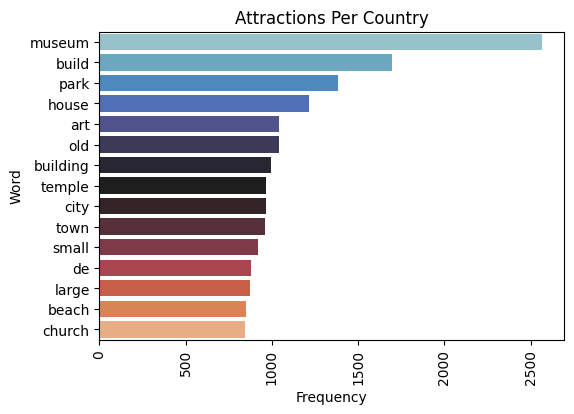

In [370]:
# Plot the 15 top words in total
words_freq_df = pd.DataFrame(words_freq[:15], columns=['Word', 'Frequency'])
words_freq_df

plt.figure(figsize=(6,4))
sns.barplot(x='Frequency', y='Word', data=words_freq_df, palette='icefire')
plt.title('Attractions Per Country')
plt.xticks(rotation=90)
plt.show()

### Top Bi-Grams For All the Countries

In [371]:
# Word Cloud for Top 15 words in Total
import nltk
nltk.download('punkt_tab')
from nltk import word_tokenize

top_words_text = words_freq_df['Word']
top_words_text
# top_words_tokens = word_tokenize(top_words_text)
# top_words_tokens

# top_tokens = word_tokenize()

# wordcloud= WordCloud()
# wordcloud.generate(top_tokens);

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rosew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0       museum
1        build
2         park
3        house
4          art
5          old
6     building
7       temple
8         city
9         town
10       small
11          de
12       large
13       beach
14      church
Name: Word, dtype: object

In [372]:
# Top Bi-Grams for All the Countries 
cv3 = CountVectorizer(analyzer='word', stop_words=stopwords_list, ngram_range=(2,2))
df_grouped = group_text_per_country(preprocessed_df, 'Lemmatized')
data4 = cv3.fit_transform(df_grouped['Lemmatized'])
df_dtm4 = pd.DataFrame(data4.toarray(), columns=cv3.get_feature_names_out())
df_dtm4.index = df_grouped.index
df_dtm4
# Transposing document term matrix
df_dtm4 = df_dtm4.transpose()
# Look at top bi-grams (in total, not per country)
sum_words = data4.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv3.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq

[('national park', 303),
 ('small museum', 129),
 ('museum house', 119),
 ('date century', 101),
 ('old town', 99),
 ('art museum', 95),
 ('contemporary art', 86),
 ('build century', 86),
 ('museum display', 84),
 ('art gallery', 82),
 ('world heritage', 79),
 ('worth visit', 68),
 ('early century', 67),
 ('buddhist temple', 66),
 ('world large', 65),
 ('museum showcase', 64),
 ('originally build', 63),
 ('southern end', 63),
 ('church build', 62),
 ('guide tour', 60),
 ('old city', 58),
 ('city centre', 57),
 ('good place', 54),
 ('main road', 50),
 ('excellent museum', 49),
 ('museum feature', 49),
 ('heritage site', 49),
 ('unesco world', 47),
 ('nature reserve', 47),
 ('bell tower', 47),
 ('city hall', 46),
 ('well know', 46),
 ('museum dedicate', 45),
 ('cultural center', 44),
 ('visitor centre', 44),
 ('city wall', 44),
 ('parque nacional', 43),
 ('beautifully restore', 43),
 ('late century', 42),
 ('cultural centre', 42),
 ('botanical garden', 42),
 ('clock tower', 41),
 ('littl

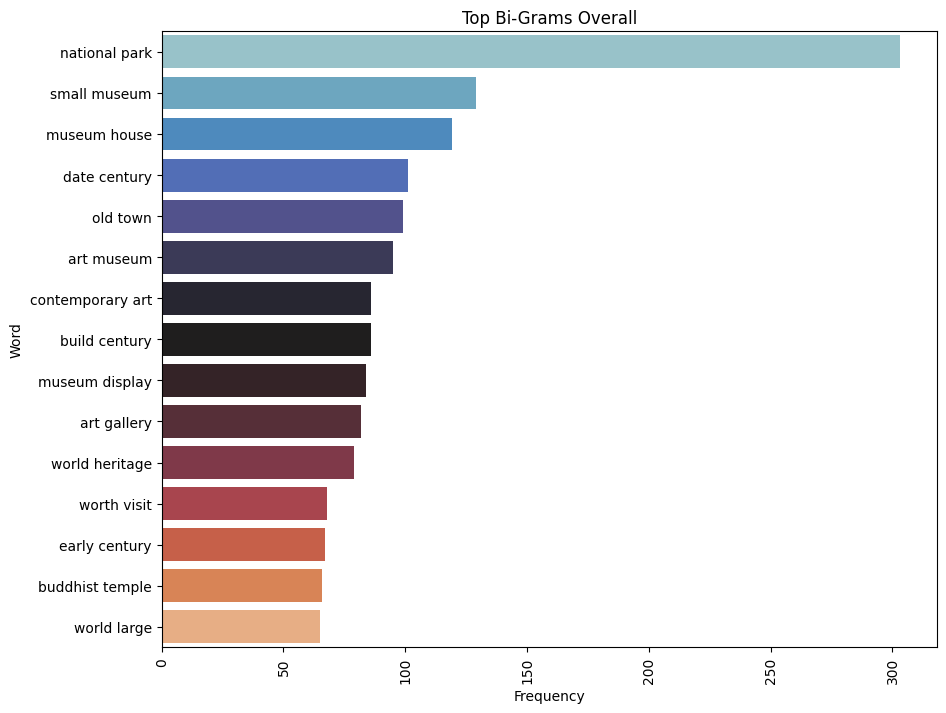

In [373]:
# Plot the 15 top Bi-Grams in total
words_freq_bi_df = pd.DataFrame(words_freq[:15], columns=['Word', 'Frequency'])
words_freq_bi_df

plt.figure(figsize=(10,8))
sns.barplot(x='Frequency', y='Word', data=words_freq_bi_df, palette='icefire')
plt.title('Top Bi-Grams Overall')
plt.xticks(rotation=90)
plt.show()

In [374]:
# Top Tri-Grams for All the Countries 
cv4 = CountVectorizer(analyzer='word', stop_words=stopwords_list, ngram_range=(3,3))
df_grouped = group_text_per_country(preprocessed_df, 'Lemmatized')
data5 = cv4.fit_transform(df_grouped['Lemmatized'])
df_dtm5 = pd.DataFrame(data5.toarray(), columns=cv4.get_feature_names_out())
df_dtm5.index = df_grouped.index
df_dtm5
# Transposing document term matrix
df_dtm5 = df_dtm5.transpose()
# Look at top tri-grams (in total, not per country)
sum_words = data5.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv4.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq

[('world heritage site', 47),
 ('unesco world heritage', 46),
 ('national historic site', 21),
 ('museum tell story', 20),
 ('world heritage list', 18),
 ('final resting place', 16),
 ('national park cover', 15),
 ('date early century', 14),
 ('traditional ornately decorate', 12),
 ('ornately decorate residence', 12),
 ('world large collection', 11),
 ('museum worth visit', 11),
 ('large national park', 10),
 ('art gallery house', 10),
 ('haveli traditional ornately', 10),
 ('build late century', 9),
 ('work local artist', 9),
 ('buddhist temple complex', 9),
 ('date late century', 9),
 ('build century ad', 9),
 ('greek orthodox church', 9),
 ('modern contemporary art', 8),
 ('natural history museum', 8),
 ('stretch white sand', 8),
 ('million year old', 8),
 ('date century bc', 8),
 ('frank lloyd wright', 8),
 ('marine national park', 8),
 ('sultan murat ii', 8),
 ('museum trace history', 7),
 ('fine art museum', 7),
 ('art include work', 7),
 ('renovation time research', 7),
 ('conte

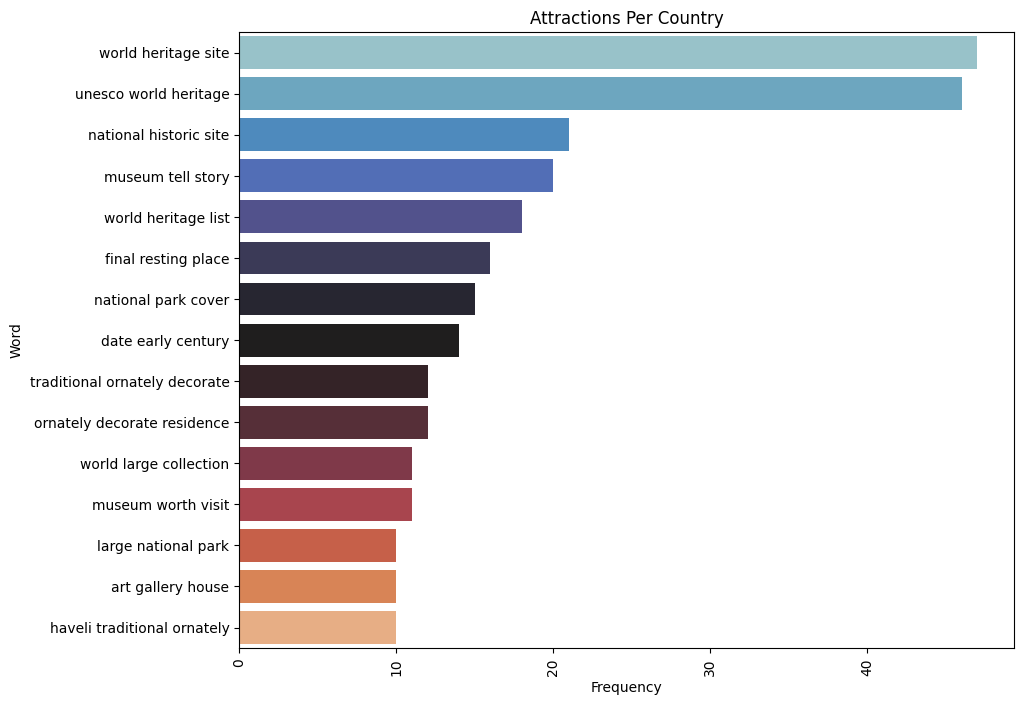

In [375]:
# Plot the 15 top Tri-Grams in total
words_freq_tri_df = pd.DataFrame(words_freq[:15], columns=['Word', 'Frequency'])
words_freq_tri_df

plt.figure(figsize=(10,8))
sns.barplot(x='Frequency', y='Word', data=words_freq_tri_df, palette='icefire')
plt.title('Attractions Per Country')
plt.xticks(rotation=90)
plt.show()

# Modeling

## Baseline Naive Bayes Model

In [637]:
# Re-import the data to get a fresh start
data = pd.read_csv('/Users//rosew/Downloads/best_travel_destinations_for_2025_df_cleaned.csv', index_col=0)
data.head()

,Attraction,Description,Country,Continent
0,Amboseli National Park,Amboseli belongs in the elite of Kenya’s natio...,Kenya,Africa
1,Fort Jesus,This 16th-century fort and Unesco World Herita...,Kenya,Africa
2,David Sheldrick Wildlife Trust,"Occupying a plot within Nairobi National Park,...",Kenya,Africa
3,Nairobi National Park,Welcome to Kenya’s most accessible yet incongr...,Kenya,Africa
4,National Museum,"Kenya’s wonderful National Museum, housed in a...",Kenya,Africa


In [638]:
# Perform train-test split before cleaning.preprocessing
X = data['Description']
y= data['Country']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((14424,), (3607,))

In [639]:
# Since this is a series, it will need to be changed to a DF for preprocessing
X_train

119      A watering hole that attracts animals, includi...
9709     This museum offers a good overview of the natu...
11414    Formed as early as 1977 from a desire to prese...
4584     One of the few nature sanctuaries within day-t...
12856    This small plantation, which produces almost-o...
                               ...                        
11290    Built in the 1840s, this shimmering tin-topped...
11972    In 1916 brothers Oscar and Marius Dufresne com...
5396     Ao Wai is a lovely beach far removed from ever...
860      Amenemhat was a 12th-dynasty governor of Oryx....
15804    About 3km south of Peppermint Bay is this top ...
Name: Description, Length: 14424, dtype: object

In [ ]:
# # Preprocess before performing train-test-split
# def preprocess_df_modeling(df, column, preview=True, lemmatize=True, remove_stopwords = True):
#     """
#     Input df with raw text descriptions.
#     Return df with preprocessed text.
#     If preview=True, returns a preview of the new df.
#     """
#     stopwords_list = stopwords.words('english')
#     stopwords_list += list(string.punctuation)
#     stopwords_list += ['sq', 'km', 'south', 'west', 'north', 'east', 'de', 'la', 'southeast', 'northeast', 'northwest', 'look', 'like', 'southwest', 'de', 'san', 'northern']

#     df[column] = df['Description'].apply(lambda x: x.lower())
#     df[column] = df[column].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
#     df[column] = df[column].apply(lambda x: re.sub('\w*\d\w*','', x))
    

#     if lemmatize:
#         df[column]= df[column].apply(lambda x: ' '.join(
#                                     [token.lemma_ for token in list(lemmatized(x)) if (token.is_stop==False)]))
    
#     if remove_stopwords:
#         df[column] = [word for word in df[column] if word not in stopwords_list]


#     if preview:
#         display(df.head(10))
        
#     return df


In [640]:
X_train_preprocessed = preprocess_df(pd.DataFrame(X_train, columns = ['Description']), 'Lemmatized')
X_test_preprocessed = preprocess_df(pd.DataFrame(X_test,  columns =['Description']), 'Lemmatized')


,Description,Lemmatized
119,"A watering hole that attracts animals, includi...",watering hole attract animal include elephant ...
9709,This museum offers a good overview of the natu...,museum offer good overview natural cultural hi...
11414,Formed as early as 1977 from a desire to prese...,form early desire preserve memory story poss...
4584,One of the few nature sanctuaries within day-t...,nature sanctuary daytrip reach mumbais city li...
12856,"This small plantation, which produces almost-o...",small plantation produce almostorganic shadegr...
4622,A few partially rebuilt wall stubs are all tha...,partially rebuild wall stub remain palace comp...
16990,The Roman harbour at the base of Kaleiçi's slo...,roman harbour base kaleiçis slope antalyas lif...
9767,Was it the fall of 1966 or the winter of ’67? ...,fall winter ' haight saying go remember summ...
12534,Staff at the visitors center of the stunning C...,staff visitor center stunning chipinque park o...
4282,The International Society for Krishna Consciou...,international society krishna consciousness ww...


,Description,Lemmatized
15937,"About 5km south of Cooktown, this 47-hectare w...",south cooktown wetland favourite birdwatch...
7759,Nero had his Domus Aurea constructed after the...,nero domus aurea construct fire ad rumour st...
7950,"A popular diving destination, these protected ...",popular diving destination protect water res...
1020,At the perennially popular Gardens there are a...,perennially popular garden actually site near ...
2864,Exhibits in this museum include the crown and ...,exhibit museum include crown personal item dai...
4463,"Isa Khan was a noble of the Sher Shah era, and...",isa khan noble sher shah era grandiose afghans...
17248,Old cars and horse-drawn carts are housed in t...,old car horsedrawn cart house silk factory gar...
1870,The Five Mountains of Aso are the smaller moun...,mountain aso small mountain asosan caldera out...
5365,Standing 14m high and weighing in at 30 tonnes...,stand high weigh tonne beautiful bronze st...
15321,Family-owned winery producing award-winning ri...,familyowne winery produce awardwinne riesle sh...


In [641]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['sq', 'km', 'one','two', 'south', 'west', 'north', 'east', 'de', 'la', 'southeast', 'northeast', 'northwest', 'look', 'like', 'southwest', 'de', 'san', 'northern']

# stopwords_list = stopwords.words('english')
# stopwords_list += list(string.punctuation)
# stopwords_list += ['sq', 'km', 'one', 'south', 'west', 'north', 'east', 'de', 'la', 'southeast', 'northeast', 'northwest', 'look', 'like', 'southwest', 'de', 'san', 'northern']

In [650]:
# Vectorize the text data to be suitable for modeling
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stopwords_list, decode_error='ignore')
# vectorizer = TfidfVectorizer(analyzer='word')
X_train_tfidf = vectorizer.fit_transform(X_train_preprocessed['Lemmatized'])
X_test_tfidf = vectorizer.transform(X_test_preprocessed['Lemmatized'])

In [651]:
sum_words22 = X_train_tfidf.sum(axis=0)
words_freq22 = [(word, sum_words22[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq22 = sorted(words_freq22, key=lambda x: x[1], reverse=True)
words_freq22

[('museum', 252.8432116258323),
 ('build', 190.1922817063354),
 ('park', 158.8981356726548),
 ('house', 148.1750203906542),
 ('art', 134.34150618824452),
 ('temple', 131.50997044239247),
 ('old', 131.14535398619532),
 ('building', 129.78690751381052),
 ('town', 125.75132115133795),
 ('city', 125.18138631404456),
 ('small', 119.37892344598552),
 ('church', 118.39815687069644),
 ('large', 113.98840618682125),
 ('beach', 112.16189431286651),
 ('century', 108.56161330941602),
 ('collection', 102.37901726407925),
 ('include', 98.9598878896615),
 ('view', 94.66637520682858),
 ('site', 94.50260544623806),
 ('home', 92.00769150367357),
 ('date', 91.70677732985625),
 ('main', 91.45364639453696),
 ('good', 88.3335063777753),
 ('history', 86.47413626839558),
 ('garden', 84.87923225077881),
 ('centre', 82.33713925760625),
 ('place', 81.95654029538758),
 ('local', 79.38509109105297),
 ('tower', 76.0866955751732),
 ('island', 75.18929511698275),
 ('display', 75.09085624163968),
 ('national', 74.5411

In [652]:
from sklearn.metrics import ConfusionMatrixDisplay
def plot_conf_matrix(y_test, y_pred):
    
    """
    Plots a confusion matrix and displays classification report.
    """
    
    
    fig, ax = plt.subplots(figsize=(12, 5))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=nb.classes_,ax =ax,
                                            normalize='true', cmap='BuGn')
        
    ax.grid(False)

    # cm = confusion_matrix(y_true, y_pred, normalize='true')
    # plt.figure(figsize=(15, 15))
    # sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.2g', annot_kws={"size": 14},
    #             xticklabels=nb.classes_, yticklabels=nb.classes_, square=True)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.show()

In [653]:
def evaluate_model(model, X_train, X_test):
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    print('Training Accuracy:', accuracy_score(y_train, y_preds_train))
    print('Testing Accuracy:', accuracy_score(y_test, y_preds_test))
    print('\n---------------\n')
    print('Training F1:', f1_score(y_train, y_preds_train, average='weighted'))
    print('Testing F1:', f1_score(y_test, y_preds_test, average='weighted'))
    print('\n---------------\n')
    print('Train Confusion Matrix\n')
    plot_conf_matrix(y_train, y_preds_train)
    print('Test Confusion Matrix\n')
    plot_conf_matrix(y_test, y_preds_test)
    print('\n----------------\n')
    print(classification_report(y_test, y_preds_test))

## Iteration One MNB

In [654]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [655]:
nb.classes_

array(['Argentina', 'Australia', 'Brazil', 'Canada', 'Chile', 'China',
       'Egypt', 'Fiji', 'France', 'Germany', 'India', 'Israel', 'Italy',
       'Japan', 'Jordan', 'Kenya', 'Mexico', 'Morocco', 'New Zealand',
       'Peru', 'South Africa', 'Thailand', 'Turkey',
       'United Arab Emirates', 'United States'], dtype='<U20')

Training Accuracy: 0.7425124792013311
Testing Accuracy: 0.5234266703631827

---------------

Training F1: 0.6812673313389652
Testing F1: 0.4754250157939932

---------------

Train Confusion Matrix



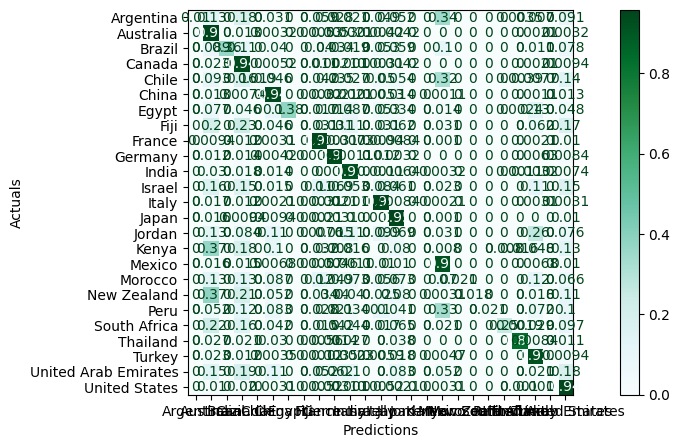

Test Confusion Matrix



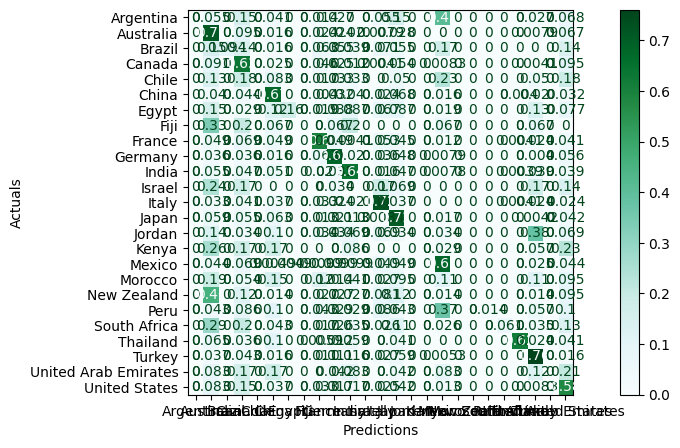


----------------

                      precision    recall  f1-score   support

           Argentina       0.00      0.00      0.00        73
           Australia       0.38      0.71      0.49       252
              Brazil       1.00      0.09      0.17       127
              Canada       0.37      0.63      0.47       241
               Chile       0.00      0.00      0.00        60
               China       0.52      0.67      0.59       249
               Egypt       0.94      0.16      0.28       104
                Fiji       0.00      0.00      0.00        15
              France       0.62      0.60      0.61       245
             Germany       0.66      0.68      0.67       252
               India       0.65      0.64      0.64       255
              Israel       0.00      0.00      0.00        29
               Italy       0.64      0.72      0.68       246
               Japan       0.48      0.71      0.57       238
              Jordan       0.00      0.00      0.0

In [656]:
evaluate_model(nb, X_train_tfidf, X_test_tfidf)

## iTERATION TWO MNB

Training Accuracy: 0.8264004437049363
Testing Accuracy: 0.5389520377044635

---------------

Training F1: 0.8097368278257866
Testing F1: 0.5072964114748401

---------------

Train Confusion Matrix



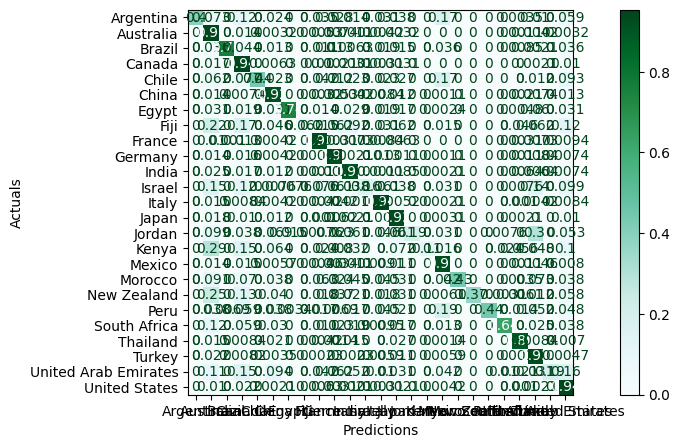

Test Confusion Matrix



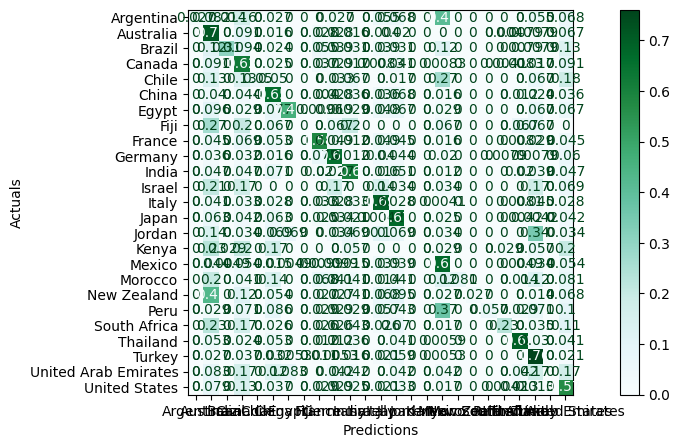


----------------

                      precision    recall  f1-score   support

           Argentina       1.00      0.03      0.05        73
           Australia       0.40      0.71      0.51       252
              Brazil       0.93      0.31      0.46       127
              Canada       0.39      0.62      0.48       241
               Chile       1.00      0.05      0.10        60
               China       0.53      0.65      0.59       249
               Egypt       0.89      0.46      0.61       104
                Fiji       0.00      0.00      0.00        15
              France       0.62      0.58      0.60       245
             Germany       0.63      0.65      0.64       252
               India       0.64      0.60      0.62       255
              Israel       0.00      0.00      0.00        29
               Italy       0.65      0.69      0.67       246
               Japan       0.52      0.67      0.58       238
              Jordan       0.00      0.00      0.0

In [657]:
# Trying Count Vectorizer to see the difference
# Vectorize the text data to be suitable for modeling
vectorizer_cv = CountVectorizer(analyzer='word', stop_words=stopwords_list, decode_error='ignore')
X_train_cv = vectorizer_cv.fit_transform(X_train_preprocessed['Lemmatized'])
X_test_cv = vectorizer_cv.transform(X_test_preprocessed['Lemmatized'])

nb = MultinomialNB()
nb.fit(X_train_cv, y_train)
evaluate_model(nb, X_train_cv, X_test_cv)


This is much more overfit, so we can keep working with TF-IDF Vectorization

## Iteration 3 MNB

## Iteration 4 MNB Using Class Weights tO Reduce class Imbalance

Training Accuracy: 0.8921242373821409
Testing Accuracy: 0.5655669531466593

---------------

Training F1: 0.8978448722886057
Testing F1: 0.5897676776545057

---------------

Train Confusion Matrix



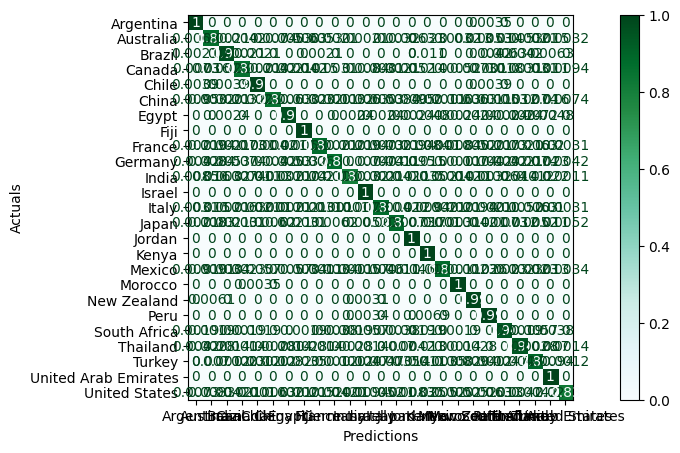

Test Confusion Matrix



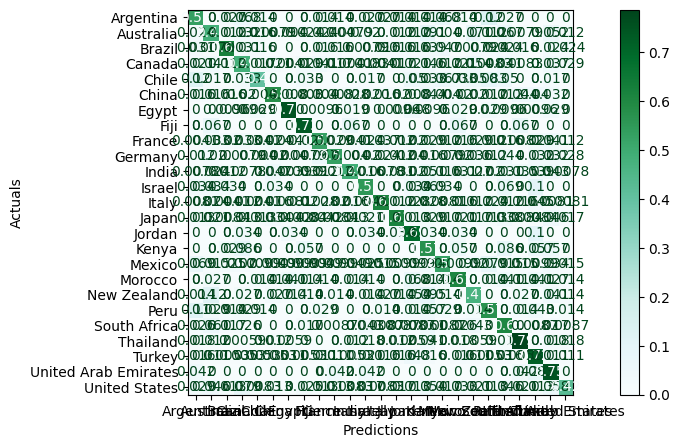


----------------

                      precision    recall  f1-score   support

           Argentina       0.33      0.53      0.41        73
           Australia       0.59      0.48      0.53       252
              Brazil       0.68      0.62      0.65       127
              Canada       0.60      0.49      0.54       241
               Chile       0.46      0.40      0.43        60
               China       0.73      0.58      0.65       249
               Egypt       0.80      0.75      0.77       104
                Fiji       0.19      0.73      0.30        15
              France       0.69      0.53      0.60       245
             Germany       0.78      0.53      0.63       252
               India       0.81      0.49      0.61       255
              Israel       0.21      0.55      0.30        29
               Italy       0.80      0.61      0.69       246
               Japan       0.76      0.61      0.68       238
              Jordan       0.20      0.69      0.3

In [578]:
# Compute class weights
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
weights_dict = dict(zip(np.unique(y_train), class_weights))
weights_dict

# Use class weights dictionary to calculate sample weight (needed for MultinomialNB)
sample_weights = y_train.map(weights_dict)
sample_weights

nb = MultinomialNB()
nb.fit(X_train_tfidf,
       y_train,
       sample_weight=sample_weights)

evaluate_model(nb, X_train_tfidf, X_test_tfidf)


While the test accuracy has increased a bit, this model is also more overfit than the first iteration

## Oversampling

In [ ]:
# pip install imblearn

### Iteration 5 SMOTE

In [590]:
from collections import Counter

# Assuming y is your target array
class_counts = Counter(y_train)
print("Class distribution:", class_counts)

Class distribution: Counter({'Japan': 962, 'United States': 960, 'Canada': 957, 'France': 955, 'Italy': 954, 'Germany': 948, 'Australia': 948, 'China': 947, 'India': 943, 'Mexico': 877, 'Turkey': 852, 'Thailand': 711, 'South Africa': 525, 'Brazil': 473, 'Egypt': 416, 'New Zealand': 326, 'Peru': 290, 'Argentina': 287, 'Morocco': 286, 'Chile': 259, 'Jordan': 131, 'Israel': 131, 'Kenya': 125, 'United Arab Emirates': 96, 'Fiji': 65})


In [629]:
majority_class_size = max(class_counts.values())
threshold = 0.1 * majority_class_size  # Classes with <10% of the majority are minority
minority_classes = [cls for cls, count in class_counts.items() if count < threshold]
print("Minority classes:", minority_classes)

Minority classes: ['Fiji', 'United Arab Emirates']


In [630]:
from imblearn.over_sampling import SMOTE
vectorizer_smote = TfidfVectorizer()
X_train_numeric = vectorizer_smote.fit_transform(X_train_preprocessed['Lemmatized'])
X_test_numeric = vectorizer_smote.transform(X_test_preprocessed['Lemmatized'])
# Target only minority classes for balancing
smote = SMOTE(sampling_strategy={cls: majority_class_size for cls in minority_classes}, random_state=42)
# processed = pd.DataFrame(X_train_preprocessed['Lemmatized'])
X_train_res, y_train_res = smote.fit_resample(X_train_numeric, y_train)

# X_train_res = X_train_res.squeeze()

model22 = MultinomialNB()
# Build a pipeline using the TF-IDF Vectorizer and Logistic Regression
model22.fit(X_train_res, y_train_res)

resampled22 = model22.predict(X_test_numeric)
train_pred22= model22.predict(X_train_res)
accuracy_score_train = accuracy_score(y_train_res, train_pred22)
accuracy_score_test = accuracy_score(y_test, resampled22)
# Verify new class distribution
# from collections import Counter
# print("New class distribution:", Counter(y_train_res))
print(accuracy_score_train)
print(accuracy_score_test)

0.7654290480014827
0.514000554477405


### Iteration 6 Random Oversampling

In [608]:
# Using Random Oversampling
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='not majority', random_state=42)


processed = pd.DataFrame(X_train_preprocessed['Lemmatized'])
X_train_res, y_train_res = oversample.fit_resample(processed, y_train)

X_train_res = X_train_res.squeeze()

ros_tfidf = TfidfVectorizer(analyzer='word', stop_words=stopwords_list, decode_error='ignore')
X_train_ros = ros_tfidf.fit_transform(X_train_res)
X_test_ros = ros_tfidf.transform(X_test_preprocessed['Lemmatized'])


model = MultinomialNB()
# Build a pipeline using the TF-IDF Vectorizer and Logistic Regression
model.fit(X_train_ros, y_train_res)

resampled = model.predict(X_test_ros)
train_pred= model.predict(X_train_ros)
accuracy_score_train = accuracy_score(y_train_res, train_pred)
accuracy_score_test = accuracy_score(y_test, resampled)

# evaluate_model(model, X_train_ros, X_test_ros)

# vectorizer_cv = CountVectorizer(analyzer='word', stop_words=stopwords_list, decode_error='ignore')
# X_train_cv = vectorizer_cv.fit_transform(X_train)
# X_test_cv = vectorizer_cv.transform(X_test)

# nb = MultinomialNB()
# nb.fit(X_train_cv, y_train)
# evaluate_model(nb, X_train_cv, X_test_cv)




# resampled = tfidfpipe.predict(X_test)
# train_pred= tfidfpipe.predict(X_train_res)
# accuracy_score_train = accuracy_score(y_train_res, train_pred)
# accuracy_score_test = accuracy_score(y_test, resampled)

print(accuracy_score_train)
print(accuracy_score_test)
# x_train


0.9340956340956341
0.5572497920709731


The random oversampled model is the most overfit of all the iterations, while SMOTE is less overfit, but still doesn't perform as well as the first iteration

# Iteration 7- Try Using Bi-Grams

Training Accuracy: 0.8517748197448697
Testing Accuracy: 0.32242861103410037

---------------

Training F1: 0.7943808600689665
Testing F1: 0.2932248657223727

---------------

Train Confusion Matrix



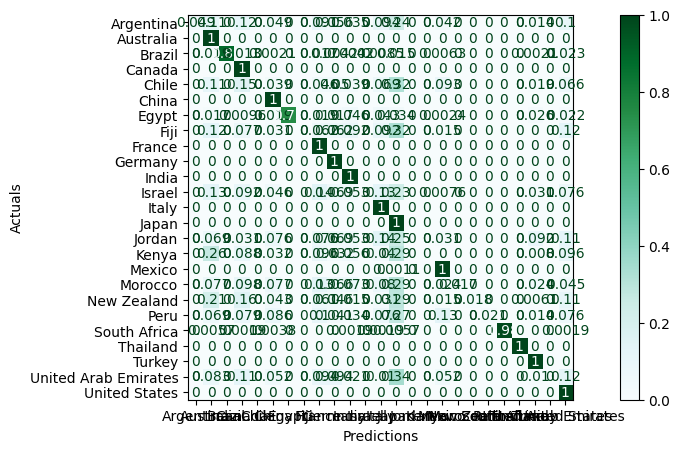

Test Confusion Matrix



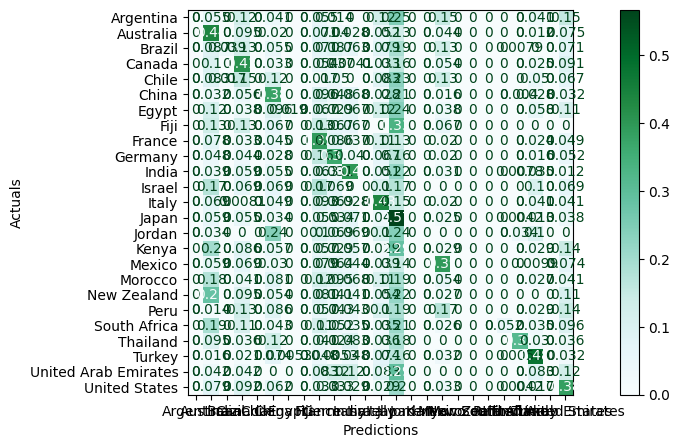


----------------

                      precision    recall  f1-score   support

           Argentina       0.00      0.00      0.00        73
           Australia       0.30      0.44      0.35       252
              Brazil       0.83      0.04      0.08       127
              Canada       0.32      0.41      0.36       241
               Chile       0.00      0.00      0.00        60
               China       0.34      0.38      0.36       249
               Egypt       0.67      0.02      0.04       104
                Fiji       0.00      0.00      0.00        15
              France       0.27      0.39      0.32       245
             Germany       0.37      0.37      0.37       252
               India       0.41      0.40      0.41       255
              Israel       0.00      0.00      0.00        29
               Italy       0.35      0.43      0.39       246
               Japan       0.18      0.57      0.28       238
              Jordan       0.00      0.00      0.0

In [631]:
bigram = TfidfVectorizer(analyzer='word',
                         stop_words=stopwords_list,
                         decode_error='ignore',
                         ngram_range=(2,2))
X_train_bg = bigram.fit_transform(X_train_preprocessed['Lemmatized'])
X_test_bg = bigram.transform(X_test_preprocessed['Lemmatized'])
nb_bg = MultinomialNB()
nb_bg.fit(X_train_bg,
          y_train)
evaluate_model(nb_bg, X_train_bg, X_test_bg)


Bigrams improve the train accuracy but the testing accuracy is highly lowered, making the model very overift.

# Try Using Random Forest
- The benefit of this is the ability to see feature importances and get more insight into how the model is working with the text data

In [658]:
vectorizer = TfidfVectorizer(analyzer='word', 
                             stop_words=stopwords_list,
                             decode_error='ignore')
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

In [659]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced')

Training Accuracy: 1.0
Testing Accuracy: 0.5281397283060715

---------------

Training F1: 1.0
Testing F1: 0.5280636812244199

---------------

Train Confusion Matrix



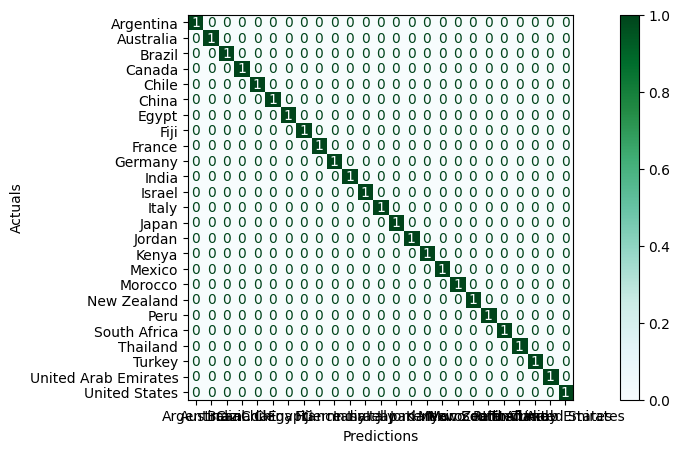

Test Confusion Matrix



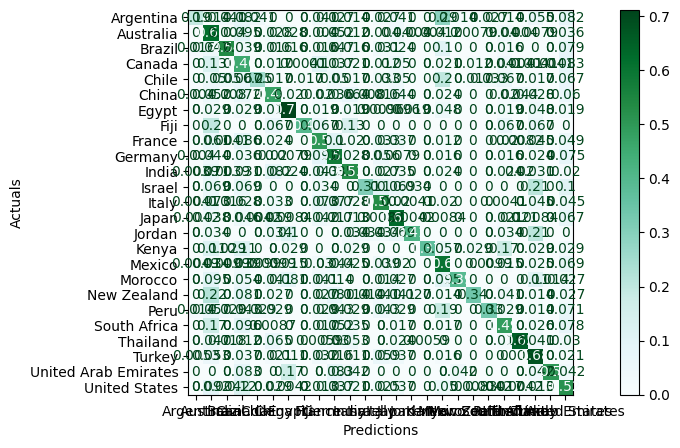


----------------

                      precision    recall  f1-score   support

           Argentina       0.58      0.19      0.29        73
           Australia       0.40      0.62      0.49       252
              Brazil       0.74      0.54      0.62       127
              Canada       0.36      0.46      0.40       241
               Chile       0.65      0.25      0.36        60
               China       0.53      0.48      0.50       249
               Egypt       0.63      0.71      0.67       104
                Fiji       0.75      0.40      0.52        15
              France       0.49      0.50      0.49       245
             Germany       0.50      0.58      0.54       252
               India       0.61      0.53      0.57       255
              Israel       0.69      0.31      0.43        29
               Italy       0.61      0.53      0.57       246
               Japan       0.59      0.63      0.61       238
              Jordan       0.60      0.41      0.4

In [633]:
evaluate_model(rf, X_train_tfidf, X_test_tfidf)

This is the worst performing model, with the training accuracy being one. 

In [636]:
#Get feature importances
feat_imps = pd.Series(rf.feature_importances_,
                      index=vectorizer.get_feature_names_out())
feat_imps[:11]

ValueError: Length of values (30816) does not match length of index (28286)

# Test Out Model

In [475]:
def preprocess_text(text):
    """
    Input raw text.
    Return preprocessed text.
    """
    
    preprocessed = text.lower()
    preprocessed = re.sub('[%s]' % re.escape(string.punctuation), '', preprocessed)
    preprocessed = re.sub('\w*\d\w*','', preprocessed)

    
    # preprocessed = lemmatized(preprocessed)
    
    
    return [preprocessed]

In [476]:
vectorizer = TfidfVectorizer(analyzer='word',
                             stop_words=stopwords_list,
                             decode_error='ignore')


In [487]:
X_train_now = vectorizer.fit_transform(X_train_res)
X_test_now = vectorizer.transform(X_test)

In [489]:
nb = MultinomialNB()
nb.fit(X_train_now, y_train_res)

MultinomialNB()

In [503]:
y_preds_test = nb.predict(X_test_now)

In [505]:
accuracy_score(y_test, y_preds_test)

0.557527030773496

In [506]:
raw_text = 'Best place for hiking and snorkeling'
preprocessed_text = preprocess_text(raw_text)
preprocessed_text

['best place for hiking and snorkeling']

In [507]:
nb.predict(vectorizer.transform(preprocessed_text))

array(['Mexico'], dtype='<U20')

In [511]:
preprocessed2 = preprocess_text('Which is the best place to visit archeological museums')
print(preprocessed2)
nb.predict(vectorizer.transform(preprocessed2))

['which is the best place to visit archeological museums']


array(['Chile'], dtype='<U20')

In [513]:
preprocessed3 = preprocess_text('Which is the best place to do Wine tastings, long walks on the beach and dinners on the beach')
print(preprocessed3)
nb.predict(vectorizer.transform(preprocessed3))

['which is the best place to do wine tastings long walks on the beach and dinners on the beach']


array(['Israel'], dtype='<U20')

In [514]:
preprocessed4 = preprocess_text('Where can I do do yoga on the beach?')
print(preprocessed4)
nb.predict(vectorizer.transform(preprocessed4))

['where can i do do yoga on the beach']


array(['New Zealand'], dtype='<U20')

In [515]:
preprocessed5 = preprocess_text('Sunset cruises on a yacht and visit museums')
print(preprocessed5)
nb.predict(vectorizer.transform(preprocessed5))

['sunset cruises on a yacht and visit museums']


array(['Jordan'], dtype='<U20')

In [496]:
preprocessed6 = preprocess_text('See rhinos and go on safari')
print(preprocessed6)
nb.predict(vectorizer.transform(preprocessed6))

['see rhinos and go on safari']


array(['South Africa'], dtype='<U20')

In [497]:
preprocessed7 = preprocess_text('See Castles')
print(preprocessed7)
nb.predict(vectorizer.transform(preprocessed7))

['see castles']


array(['United Arab Emirates'], dtype='<U20')